In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('chun.csv')

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
data.shape

(7043, 21)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.00,7043.00,7043.00
mean,0.16,32.37,64.76
std,0.37,24.56,30.09
min,0.00,0.00,18.25
25%,0.00,9.00,35.50
50%,0.00,29.00,70.35
75%,0.00,55.00,89.85
max,1.00,72.00,118.75


In [10]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)

for c in categorical_columns:
    data[c] = data[c].str.lower().str.replace(' ', '_')

data.totalcharges = pd.to_numeric(data.totalcharges, errors='coerce')
data.totalcharges = data.totalcharges.fillna(0)

data.churn = (data.churn == 'yes').astype(int)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score
from collections import Counter


In [51]:
data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

y_train = data_train.churn.values
y_val = data_val.churn.values
y_test = data_test.churn.values

del data_train['churn']
del data_val['churn']
del data_test['churn']

In [13]:
#x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [14]:
data.nunique()

customerid          7043
gender                 2
seniorcitizen          2
partner                2
dependents             2
tenure                73
phoneservice           2
multiplelines          3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
contract               3
paperlessbilling       2
paymentmethod          4
monthlycharges      1585
totalcharges        6531
churn                  2
dtype: int64

In [15]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [16]:
dv = DictVectorizer(sparse=False)

train_new = data_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_new)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [17]:
val_new = data_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_new)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [19]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [20]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


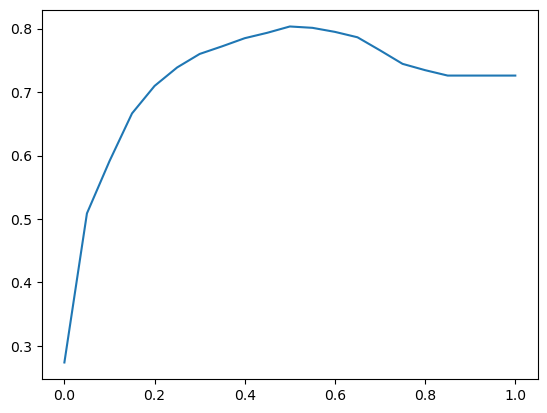

In [21]:
plt.plot(thresholds, scores)

In [23]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [24]:
1 - y_val.mean()

0.7260468417317246

## Confusion Matrix

In [25]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [26]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [27]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [29]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [30]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

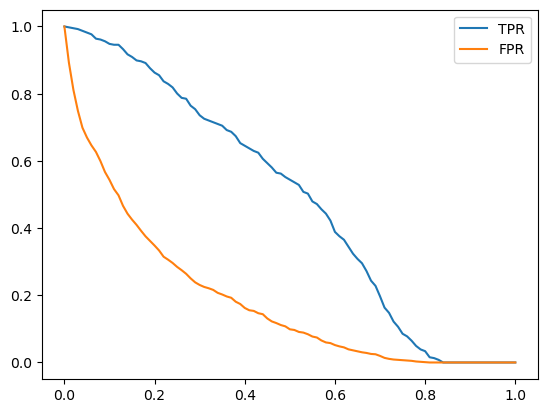

In [31]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Trying Random Model

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [33]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [34]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [35]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

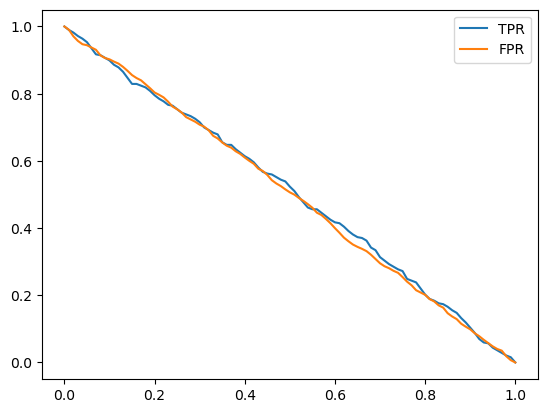

In [36]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

In [37]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

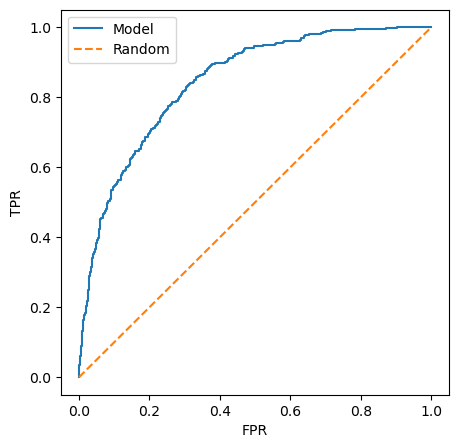

In [39]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## Cross-Validation

In [40]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [42]:
dv, model = train(data_train, y_train, C=0.001)

In [43]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [45]:
y_pred = predict(data_val, dv, model)

In [47]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [53]:
import pickle

In [ ]:
output_file = 